In [2]:
import json, datetime, time, random, re, collections, os, chardet, ast
import pandas as pd

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

from sqlalchemy import create_engine, inspect, Table, MetaData, select, Column, String, ARRAY, func, Integer
from sqlalchemy.orm import declarative_base, scoped_session, sessionmaker, Session

# Define custom plotly template
custom_template = go.layout.Template()
custom_template.layout = go.Layout(
    font=dict(family="Arial", size=14, color='white'),
    title=dict(font=dict(size=24, color='white')),
    plot_bgcolor='black',
    paper_bgcolor='black',
    yaxis=dict(
        showgrid=True,
        gridcolor='darkgrey',
        gridwidth=1,
        zeroline=True
    ),
    colorway=['#F67661', '#FFFF5B', '#C48130', '#888720', '#448539', '#007C5C', '#1B3D2F', '#006F7A']
)
pio.templates['custom'] = custom_template
pio.templates.default = 'custom'

# 0) Outline

The goal of this project is to compare sources used by Google vs Perplexity.

I use this notebook for data exploration and analysis.

## I) Functions and Classes

In [4]:
class DBConnection():
    '''
    Connection to a table in my Postgres database for news articles.
    '''
    def __init__(self, host, port, db_name, username, password, table_name):
        self.host = host
        self.port = port
        self.db_name = db_name
        self.username = username
        self.password = password
        self.engine = create_engine(f'postgresql://{self.username}:{self.password}@{self.host}:{self.port}/{self.db_name}?sslmode=require')
        self.metadata = MetaData()
        self.table_name = table_name
        self.Base = declarative_base()
        self.TableClass = self.create_table_class()        
        self.Session = scoped_session(sessionmaker(bind=self.engine))

    def get_engine(self):
        '''
        Returns the engine
        '''
        return self.engine

    
    def create_table_class(self):
        '''
        Creates an SQLAlchemy table using the Base class.
        Uses the specified schema if tables does not yet exist.
        If it exists, it reads the table schema from the db.
        '''
        if not self.engine.dialect.has_table(self.engine.connect(), self.table_name):
            class TableClass(self.Base):
                __tablename__ = self.table_name
                id = Column(Integer, primary_key=True)
                category = Column(String)
                subcategory0 = Column(String)
                subcategory1 = Column(String)
                query = Column(String)
                google = Column(ARRAY(String))
                perplexity = Column(ARRAY(String))
            return TableClass
        else:
            class TableClass(self.Base):
                __table__ = Table(self.table_name, self.metadata, autoload_with=self.engine)
            return TableClass


    def create_table(self):
        '''
        Creates a new table if it does not yet exist.
        '''
        if not self.engine.dialect.has_table(self.engine.connect(), self.table_name):
            self.Base.metadata.create_all(self.engine)
            print(f'The following table has been created: {self.table_name}')


    def write_to_db(self, results):
        '''
        Takes a list of entries (dict) and writes it to the db.
        '''
        with self.Session() as session:
            objects = [self.TableClass(**entry) for entry in results]
            session.bulk_save_objects(objects)
            session.commit()


    def read_from_db(self, entry_id=None):
        '''
        Reads from the database.
        If entry_id is specified, it returns a single entry.
        Otherwise it returns all entries as a DataFrame.
        :param int entry_id: The id to retrieve
        '''
        with self.Session() as session:
            if entry_id:
                result = session.query(self.TableClass).filter_by(id=entry_id).first()
                return result
            else: 
                result = [x for x in session.query(self.TableClass).all()]
                df = pd.DataFrame([x.__dict__ for x in result])
                df.drop('_sa_instance_state', axis=1, inplace=True)
                return df


    def update_entry(self, entry_id, column, new_value):
        '''
        Updates a column for a given id.
        :param int entry_id: The id of the row to update
        :param str column: The name of the column to update
        :param new_value: The new value
        '''
        with self.Session() as session:
            try:
                entry = self.read_from_db(entry_id)
                if not entry:
                    print('No entry found with this ID.')
                    return False
                elif not hasattr(self.TableClass, column):
                    print('Column does not exist in this table.')
                    return False
                else:
                    session.query(self.TableClass).filter_by(id=entry_id).update({column: new_value})
                    session.commit()
            except Exception as e:
                print(e)

In [5]:
def num_sources_per_category(df, category_type=None, category=None):
    '''
    Calculates the number of unique sources per category.
    If no category_type and category are stated,
    it will compute the sources over the whole dataset.
    Only takes into account the top 5 sources.
    :param DataFrame df: The dataframe.
    :param str category_type: The type of category (i.e. subcategory0).
    :param str category: The name of the category to filter by.
    '''
    google_sources = []
    perplexity_sources = []
    for i, r in df.iterrows():
        if category_type and category:
            if r[category_type] == category:
                google_sources.extend(r['google'][:5])
                perplexity_sources.extend(r['perplexity'][:5])
        else:
            google_sources.extend(r['google'][:5])
            perplexity_sources.extend(r['perplexity'][:5])
    return collections.Counter(google_sources), collections.Counter(perplexity_sources)

In [6]:
def get_queries_for_category(df, category_type, category):
    '''
    Returns a list of queries for a given category.
    :param DataFrame df: The dataframe.
    :param str category_type: The type of category (i.e. subcategory0).
    :param str category: The name of the category to filter by.
    '''
    return df.loc[df[category_type] == category, 'query'].tolist()

In [7]:
# gelb FFFF5B
# orange F67661
# grün 1B3D2F
def visualize_sources_per_category_barchart(data, category):
    '''
    Creates a pair of bar plots with the frequency of sources for a given category.
    :param dict data: Dict with {<category>: {<google>: [(term, frequency)], <perp>: [(term, frequency)]}}
    :param str category: The category to display
    '''
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Google', 'Perplexity'])
    fig.add_trace(
        go.Bar(
            x=[x[0] for x in data[category]['google']],
            y=[x[1] for x in data[category]['google']],
            marker_color='#F67661',
            showlegend=False
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Bar(
            x=[x[0] for x in data[category]['perp']],
            y=[x[1] for x in data[category]['perp']],
            marker_color='#F67661',
            showlegend=False
        ),
        row=1, col=2
    )
    fig.update_layout(
        title=f'Top-10 Sources - {category}',
        template='plotly_dark',
        height=500,
        paper_bgcolor='black',
        plot_bgcolor='black'
    )
    fig.update_xaxes(title='Source')
    fig.update_yaxes(title='Frequency')
    return fig

In [8]:
# OLD VERSION: Does not take into account the actual overlap for the single queries
def visualize_sources_intersection_piechart(df, category_type=None, category=None):
    '''
    Creates a pie chart visualizing sources unique to Perplexity and Google as well as their intersection by
    category or for the whole dataset. Does not take into account the overlap for a single search query.
    :param DataFrame df: The data from the db exported as a DataFrame
    :param str category_type: The type of category to filter by (column in df)
    :param str category: The category to filter by
    '''
    google_sources = []
    perplexity_sources = []
    if category_type and category:
        for i, row in df.iterrows():
            if row[category_type] == category:
                google_sources.extend(row['google'][:5])
                perplexity_sources.extend(row['perplexity'][:5])
    elif category_type and not category:
        raise AttributeError('category_type and category must both be set')
    elif not category_type and category:
        raise AttributeError('category_type and category must both be set')
    else:
        for i, row in df.iterrows():
            google_sources.extend(row['google'][:5])
            perplexity_sources.extend(row['perplexity'][:5])
    google_sources = set(google_sources)
    perplexity_sources = set(perplexity_sources)
    total = perplexity_sources.union(google_sources)
    google_unique = google_sources.difference(perplexity_sources)
    perplexity_unique = perplexity_sources.difference(google_sources)
    intersection = google_sources.intersection(perplexity_sources)
    fig = go.Figure(
        data=[go.Pie(
            labels=['Google', 'Perplexity', 'Shared'],
            values=[len(google_unique), len(perplexity_unique), len(intersection)]
        )]
    )
    fig.update_traces(
        marker=dict(
            colors=['#F7906E', '#B58580', '#943B20']
        )
    )
    fig.update_layout(
        title='Share of Unique Sources Used by Google vs. Perplexity',
        template='plotly_white',
        height=600,
        width=600
    )
    return fig

In [9]:
def visualize_sources_overlap_piechart(df, category_type=None, category=None):
    '''
    Creates a pie chart visualizing sources unique to Perplexity and Google as well as their overlap.
    :param DataFrame df: The data from the db exported as a DataFrame
    :param str category_type: The type of category to filter by (column in df)
    :param str category: The category to filter by
    '''
    if category_type and category:
        google_unique = df.loc[df[category_type] == category, 'google_unique_percentage'].mean()
        perplexity_unique = df.loc[df[category_type] == category, 'perplexity_unique_percentage'].mean()
        overlap = df.loc[df[category_type] == category, 'overlap_percentage'].mean()
    elif category_type and not category:
        raise AttributeError('category_type and category must both be set')
    elif not category_type and category:
        raise AttributeError('category_type and category must both be set')
    else:
        google_unique = df['google_unique_percentage'].mean()
        perplexity_unique = df['perplexity_unique_percentage'].mean()
        overlap = df['overlap_percentage'].mean()
        
    fig = go.Figure(
        data=[go.Pie(
            labels=['Google', 'Perplexity', 'Shared'],
            values=[google_unique, perplexity_unique, overlap]
        )]
    )
    fig.update_layout(
        title='Share of Unique Sources Used by Google vs. Perplexity',
        height=600,
        width=600
    )
    return fig

In [10]:
def visualize_sources_per_category_table(data, category):
    '''
    Visualizes unique sources for a given category using a table.
    :param dict data: Dict with {<category>: {<google>: [(term, frequency)], <perp>: [(term, frequency)]}}
    :param str category: The category to display
    '''
    google_sources = [x[0] for x in sources_per_category[category]['google']]
    perp_sources = [x[0] for x in sources_per_category[category]['perp']]
    unique_sources = set(google_sources + perp_sources)
    google = []
    perp = []
    for x in unique_sources:
        if x in google_sources:
            google.append(1)
        else:
            google.append(0)
        if x in perp_sources:
            perp.append(1)
        else:
            perp.append(0)
    data = list(zip(google, perp))
    fig = go.Figure(
    data=go.Heatmap(
        z=data,
        showscale=False,
        colorscale=['#F7906E', 'lightgrey']
        )
    )
    annotations = []
    for i, v in enumerate(data):
        annotations.append(
            {
                'x': 0,
                'y': i,
                'text': list(unique_sources)[i],
                'showarrow': False
            }
        )
        annotations.append(
            {
                'x': 1,
                'y': i,
                'text': list(unique_sources)[i],
                'showarrow': False
            }
        )
    fig.update_layout(
        title=category,
        height=800,
        width=600,
        yaxis=dict(tickvals=[],ticktext=[]),
        xaxis=dict(tickvals=[],ticktext=[]),
        annotations=annotations
    )
    return fig

In [11]:
def visualize_sources_per_category_venn(data, category):
    '''
    Visualizes unique sources for a given category using a Venn diagram.
    :param dict data: Dict with {<category>: {<google>: [(term, frequency)], <perp>: [(term, frequency)]}}
    :param str category: The category to display
    '''
    # Prepare data
    all_google_sources = [x[0] for x in data[category]['google']]
    all_perp_sources = [x[0] for x in data[category]['perp']]
    common = set(all_google_sources).intersection(set(all_perp_sources))
    google_sources = set(all_google_sources) - set(all_perp_sources)
    perp_sources = set(all_perp_sources) - set(all_google_sources)
    # Create figure
    fig = go.Figure()
    height = 900
    width = height * 1.5
    font_size = 15
    circle_bottom = height/8
    circle_top = 7*height/8
    circle_height = circle_top - circle_bottom
    equal_space_common = circle_height / (len(common) + 1)
    equal_space_google = circle_height / (len(google_sources) + 1)
    equal_space_perp = circle_height / (len(perp_sources) + 1)
    fig.add_shape(
        type='circle',
        x0=0,
        x1=5.5*width/8,
        y0=circle_bottom,
        y1=circle_top,
        fillcolor='#F67661',
        line_color='#F67661',
        opacity=0.8
    )
    fig.add_shape(
        type='circle',
        x0=2.5*width/8,
        x1=8*width/8,
        y0=circle_bottom,
        y1=circle_top,
        fillcolor='#F67661',
        line_color='#F67661',
        opacity=0.8
    )
    for i, v in enumerate(google_sources):
        position = circle_bottom + equal_space_google * (i + 1)
        fig.add_annotation(x=2*width/8, y=position, text=v, showarrow=False, font=dict(size=font_size, weight='bold', color='black'))
    for i, v in enumerate(common):
        position = circle_bottom + equal_space_common * (i + 1)
        fig.add_annotation(x=width/2, y=position, text=v, showarrow=False, font=dict(size=font_size, weight='bold', color='black'))
    for i, v in enumerate(perp_sources):
        position = circle_bottom + equal_space_perp * (i + 1)
        fig.add_annotation(x=6*width/8, y=position, text=v, showarrow=False, font=dict(size=font_size, weight='bold', color='black'))
    fig.add_annotation(x=2.5*width/8, y=circle_top*1.1, text='Google', showarrow=False, font=dict(size=24, color='white', weight='bold'))
    fig.add_annotation(x=5.5*width/8, y=circle_top*1.1, text='Perplexity', showarrow=False, font=dict(size=24, color='white', weight='bold'))
    fig.update_layout(
        title=category,
        showlegend=False,
        width=width,
        height=height,
        template='plotly_dark',
        paper_bgcolor='black',
        plot_bgcolor='black',
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            visible=False,
            scaleanchor='y',
            scaleratio=1,
            range=[0, width]
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            visible=False,
            range=[0, height]
        )
    )
    return fig

In [12]:
def visualize_sources_distribution_hist(df, category_type, category):
    '''
    Creates a histogram showing the distribution of number of sources used in a given category.
    :param DataFrame df: The dataframe.
    :param str category_type: The type of category (i.e. subcategory0).
    :param str category: The name of the category to filter by.
    '''
    google, perp = num_sources_per_category(df, category_type, category)
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=list(google.values()),
        nbinsx=10,
        xbins=dict(
            start=0,
            end=max(list(google.values()))
        ),
        marker_color='#F7906E',
        name='Google'
    ))
    fig.add_trace(go.Histogram(
        x=list(perp.values()),
        nbinsx=10,
        xbins=dict(
            start=0,
            end=max(list(perp.values()))
        ),
        marker_color='#1b3d2f',
        name='Perplexity'
    ))
    fig.update_layout(
        title='Number Occurences per Source in a Category',
        height=600,
        template='plotly_white',
        barmode='overlay'
    )
    fig.update_traces(opacity=0.8)
    return fig

## II) Load, Clean Prepare Data

In [14]:
df = db.read_from_db()

In [15]:
# Add columns with number of sources
df['num_google'] = df['google'].apply(lambda x: len(x))
df['num_perplexity'] = df['perplexity'].apply(lambda x: len(x))

In [16]:
# Add columns: unique sources
sources_intersection = []
all_unique_sources = []
unique_sources_google = []
unique_sources_perplexity = []
for i, row in df.iterrows():
    google_sources = set(row['google'][:5])
    perplexity_sources = set(row['perplexity'][:5])
    sources_intersection.append(google_sources.intersection(perplexity_sources))
    all_unique_sources.append(perplexity_sources.union(google_sources))
    unique_sources_google.append(google_sources.difference(perplexity_sources))
    unique_sources_perplexity.append(perplexity_sources.difference(google_sources))
df['sources_intersection'] = sources_intersection
df['all_unique_sources'] = all_unique_sources
df['unique_sources_google'] = unique_sources_google
df['unique_sources_perplexity'] = unique_sources_perplexity

In [17]:
# Add columns: Ratios of sources
google_unique_percentage = []
perplexity_unique_percentage = []
overlap_percentage = []
for i, row in df.iterrows():
    google_unique_percentage.append(len(row['unique_sources_google']) / len(row['all_unique_sources']))
    perplexity_unique_percentage.append(len(row['unique_sources_perplexity']) / len(row['all_unique_sources']))
    overlap_percentage.append(len(row['sources_intersection']) / len(row['all_unique_sources']))
df['google_unique_percentage'] = google_unique_percentage
df['perplexity_unique_percentage'] = perplexity_unique_percentage
df['overlap_percentage'] = overlap_percentage

In [20]:
df.to_csv('./sources_final.csv')

## III) Analysis

### What are the top-10 sources used?

In [18]:
# What are the top-10 sources for the whole dataset?
google_sources_total, perp_sources_total = num_sources_per_category(df)
most_common_total_google = google_sources_total.most_common()[:10]
most_common_total_perp = perp_sources_total.most_common()[:10]

In [19]:
# What are the top-10 sources for each of the subcategories (subcategory1)?
categories = list(df['subcategory1'].unique())
sources_per_category = {}
for category in categories:
    google, perp = num_sources_per_category(df, category_type='subcategory1', category=category)
    sources_per_category[category] = {
        'google': google.most_common()[:10],
        'perp': perp.most_common()[:10]
    }

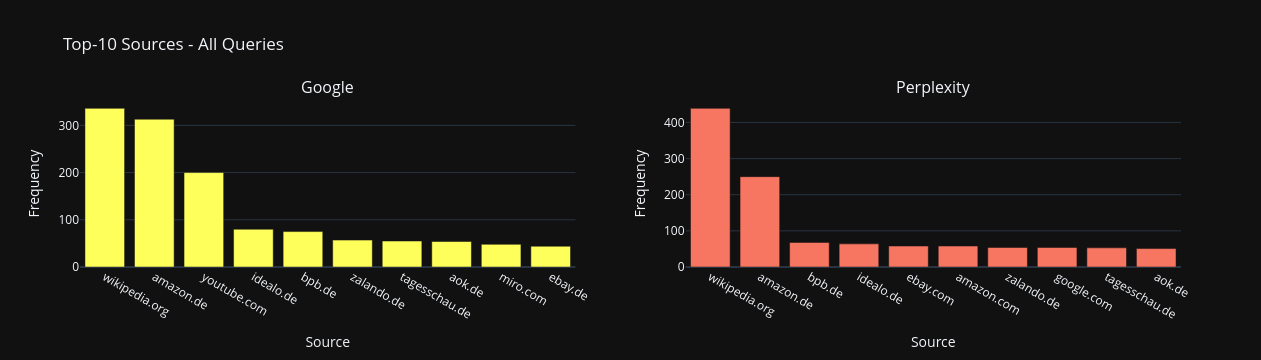

In [20]:
# What are top-ten sources used for all queries?
fig = make_subplots(rows=1, cols=2, subplot_titles=['Google', 'Perplexity'])
fig.add_trace(
    go.Bar(
        x=[x[0] for x in most_common_total_google],
        y=[x[1] for x in most_common_total_google],
        marker_color='#FFFF5B',
        showlegend=False
    ),
    row=1, col=1
)
fig.add_trace(
    go.Bar(
        x=[x[0] for x in most_common_total_perp],
        y=[x[1] for x in most_common_total_perp],
        marker_color='#F67661',
        showlegend=False
    ),
    row=1, col=2
)
fig.update_layout(
    title=f'Top-10 Sources - All Queries',
    template='plotly_dark',
    height=400
)
fig.update_xaxes(title='Source')
fig.update_yaxes(title='Frequency')

### Share of common sources for all queries

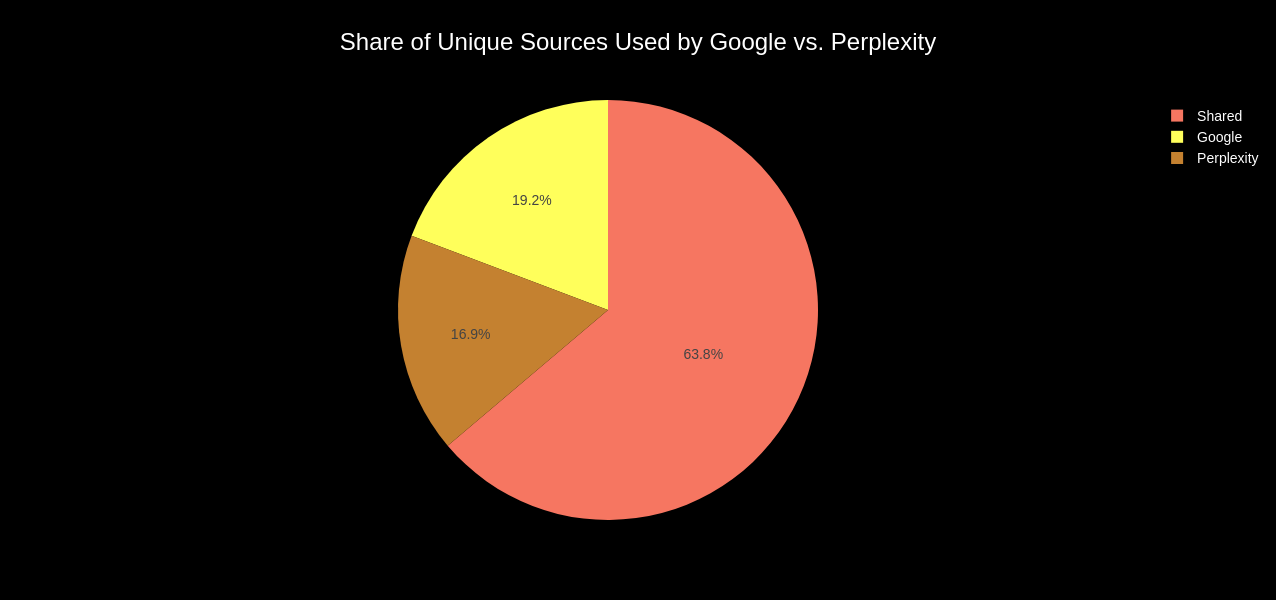

In [28]:
visualize_sources_overlap_piechart(df)

### Share of common sources per category

In [29]:
# Highest and lowest rate of shared sources in the top-5
result = []
categories = set(df['subcategory1'].tolist())
for category in categories:
    result.append({
        'category': category,
        'overlap': round(df.loc[df['subcategory1'] == category, 'overlap_percentage'].mean() * 100, 2)
    })
print(sorted(result, key=lambda x: x['overlap'], reverse=True)[0], sorted(result, key=lambda x: x['overlap'], reverse=True)[-1])

{'category': 'politik', 'overlap': np.float64(74.06)} {'category': 'marketingdienstleistungen', 'overlap': np.float64(46.26)}


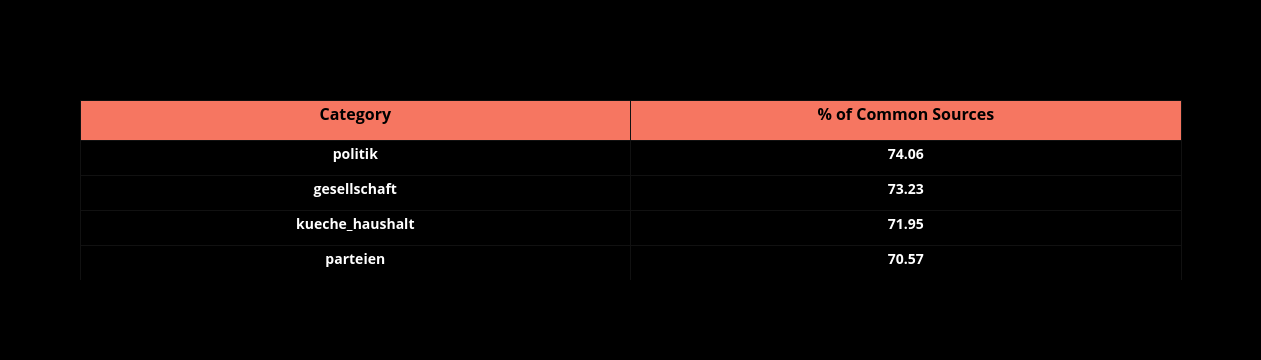

In [30]:
# gelb FFFF5B
# orange F67661
# grün 1B3D2F
sorted_result = sorted(result, key=lambda x: x['overlap'], reverse=True)
fig = go.Figure(
    data=[go.Table(header=dict(
        values=['Category', '% of Common Sources'],
        fill_color='#F67661',
        font=dict(color='black', size=16, weight='bold'),
        height=40
    ),
    cells=dict(
        values=[[x['category'] for x in sorted_result], [x['overlap'] for x in sorted_result]],
        fill_color='black',
        font=dict(size=14, color='white', weight='bold'),
        height=35
    )
    )]
)
fig.update_layout(
    height=900,
    template='plotly_dark',
    paper_bgcolor='black'
)

### What might explain the difference between the categories with the most and the least common sources?

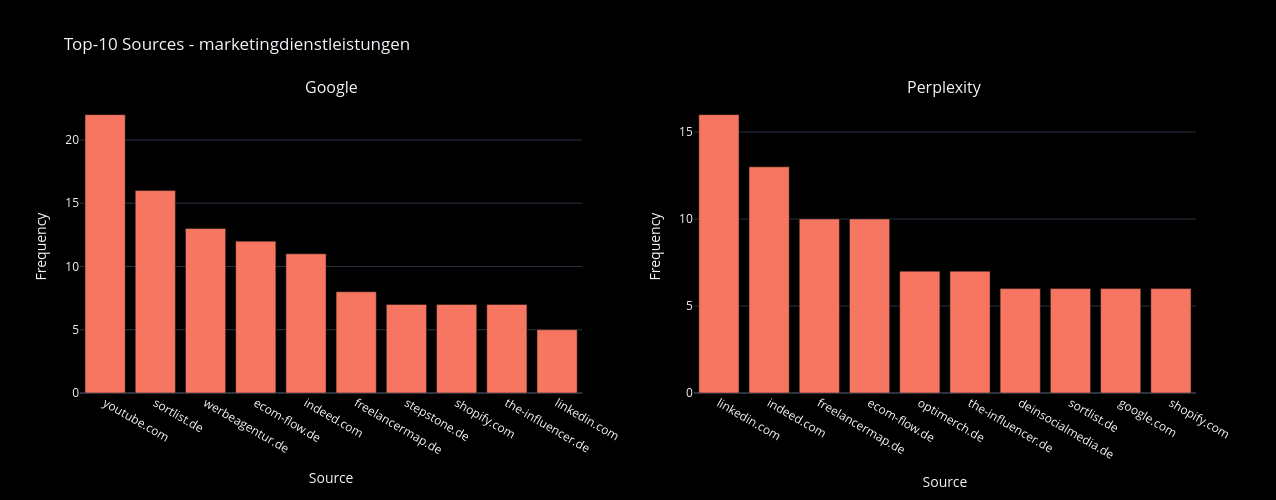

In [31]:
# Comparing the top-ten sources for "marketingdienstleistungen"
visualize_sources_per_category_barchart(sources_per_category, 'marketingdienstleistungen')

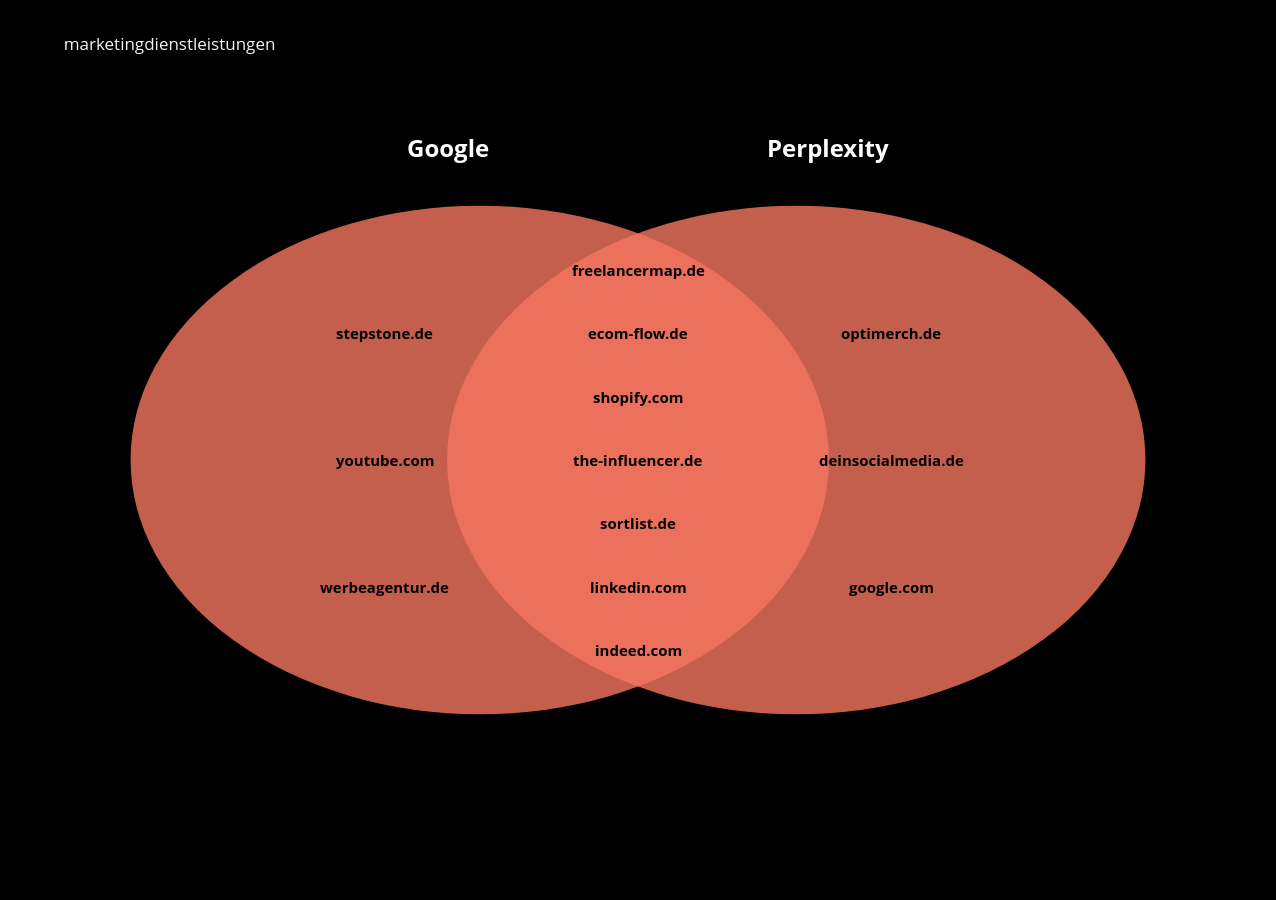

In [32]:
# Common sources for "marketingdienstleistungen"
visualize_sources_per_category_venn(sources_per_category, 'marketingdienstleistungen')

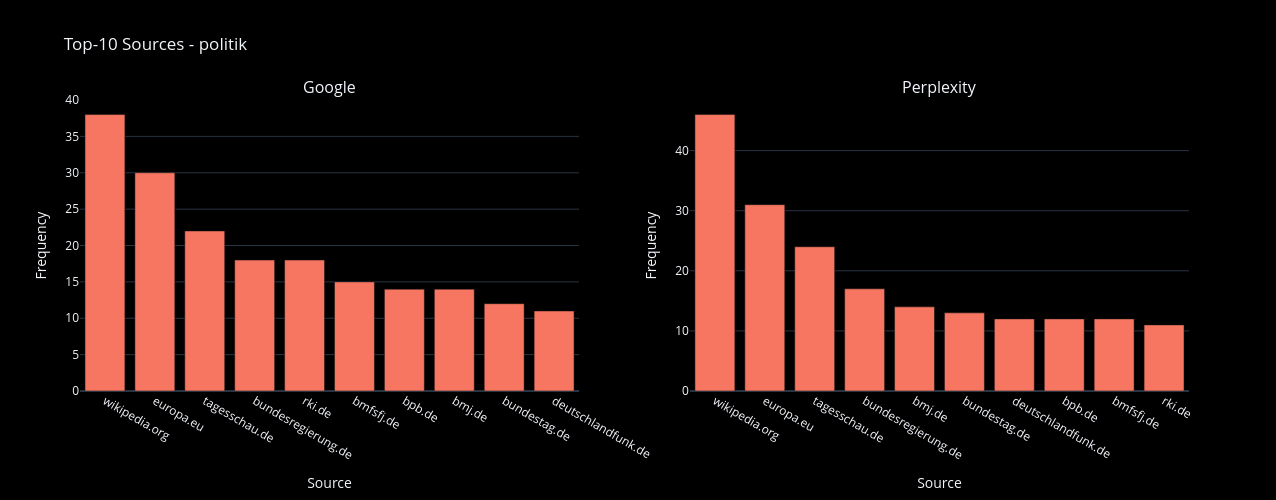

In [33]:
# Comparing the top-ten sources for "fitness"
visualize_sources_per_category_barchart(sources_per_category, 'politik')

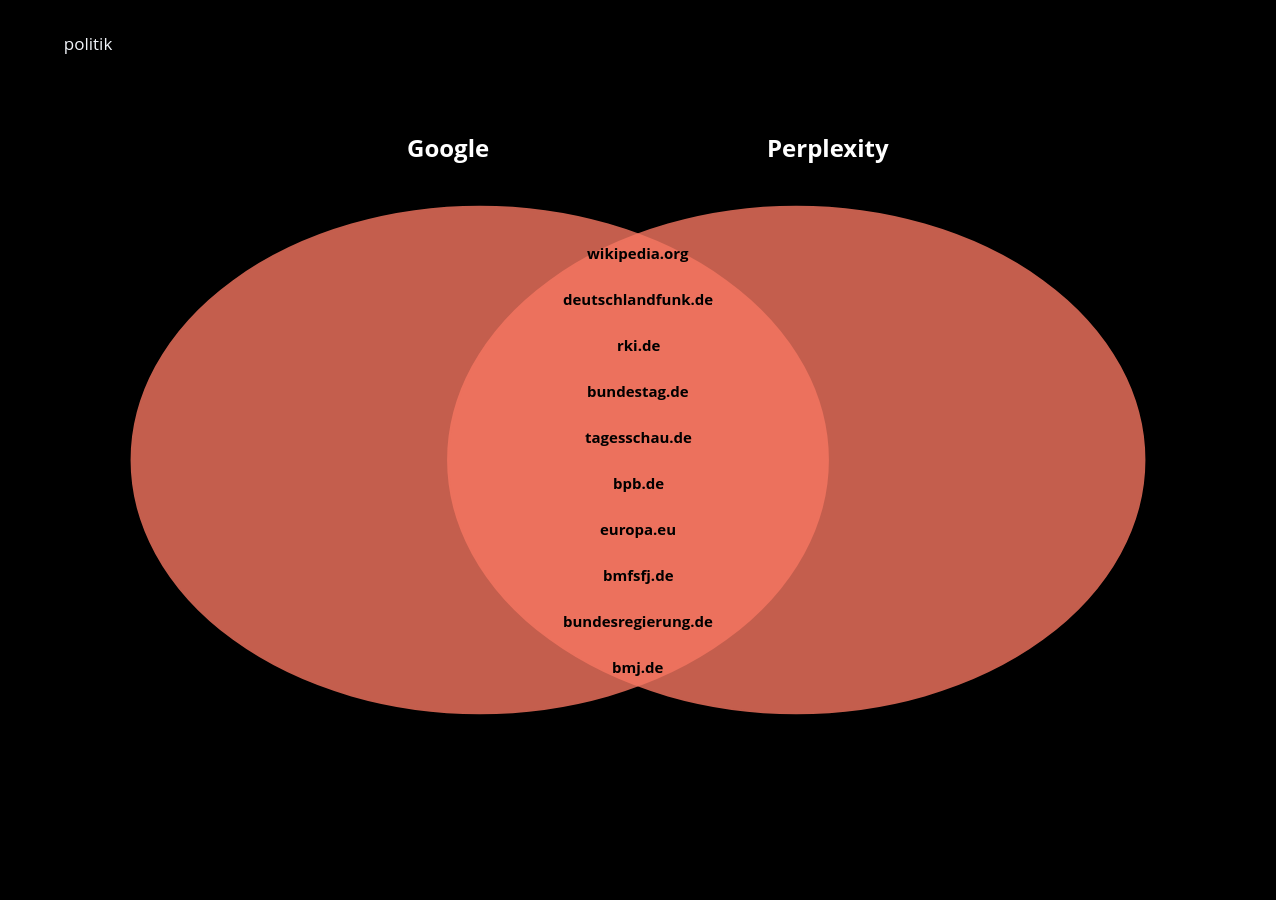

In [34]:
# Common sources for "fitness"?
visualize_sources_per_category_venn(sources_per_category, 'politik')

In [35]:
# Queries used for "marketingdienstleistungen" and "fitness"
marketingdienstleistungen = get_queries_for_category(df, 'subcategory1', 'marketingdienstleistungen')
fitness = get_queries_for_category(df, 'subcategory1', 'fitness')
pd.DataFrame({'marketingdienstleistungen': marketingdienstleistungen, 'fitness': fitness})

marketingdienstleistungen  \
0                    content creator   
1           content creator hannover   
2            content creator minijob   
3          content creator qualities   
4    content creator für unternehmen   
..                               ...   
95         werbeagentur social media   
96  social media agentur tätigkeiten   
97             seo agentur wiesbaden   
98      content agentur social media   
99              copywriter instagram   

                                             fitness  
0                                        achtsamkeit  
1                                   achtsamkeit ruhr  
2                                   achtsamkeit buch  
3                            achtsamkeit entspannung  
4                                arbor seminare 2021  
..                                               ...  
95                            rohkost ernährungsplan  
96                  gesunde ernährung nach darmkrebs  
97                         kollagen für muskelaufbau  
98                        muskelaufbau körpergewicht  
99  die besten nahrungsergänzungsmittel muskelaufbau  

[100 rows x 2 columns]

In [36]:
# All sources for "marketingdienstleistungen" vs "fitness"
marketingdienstleistungen_google, marketingdienstleistungen_perplexity = num_sources_per_category(df, 'subcategory1', 'marketingdienstleistungen')
fitness_google, fitness_perplexity = num_sources_per_category(df, 'subcategory1', 'fitness')

### Number of unique sources used per category

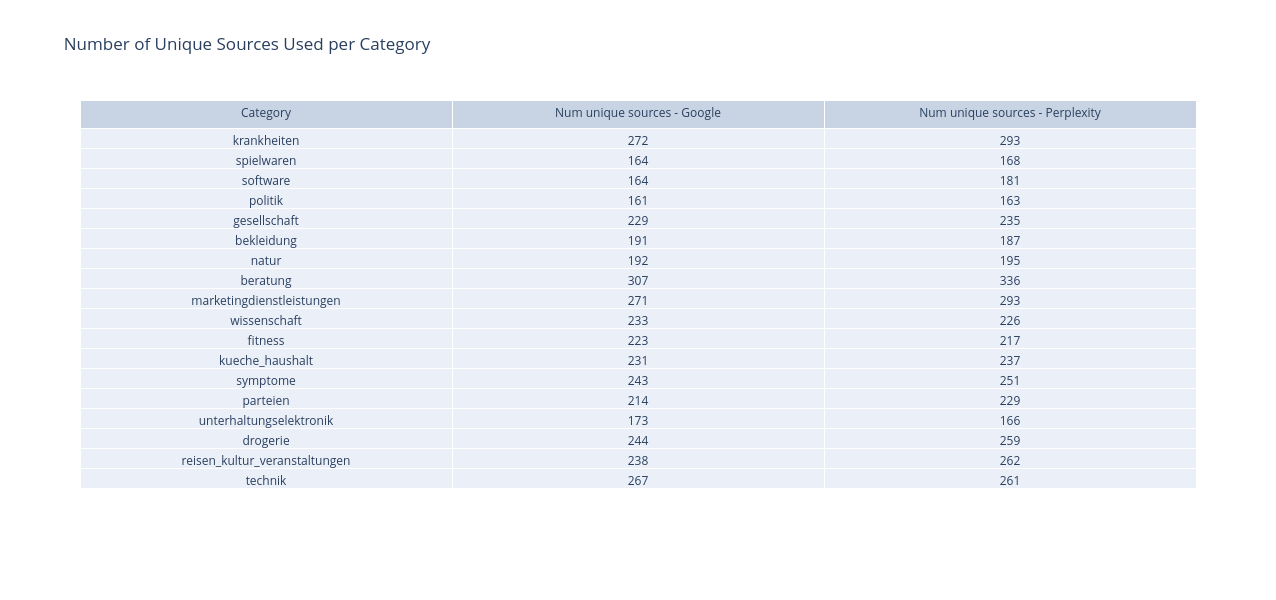

In [37]:
# Number of unique sources used per category
num_sources_per_category = []
categories = set(df['subcategory1'].tolist())
for category in categories:
    google_sources = []
    perplexity_sources = []
    for i, row in df.iterrows():
        if row['subcategory1'] == category:
            google_sources.extend(row['google'][:5])
            perplexity_sources.extend(row['perplexity'][:5])
    num_sources_per_category.append({
        'category': category,
        'num_sources_google': len(list(set(google_sources))),
        'num_sources_perplexity': len(list(set(perplexity_sources)))
    })

# Plot
fig = go.Figure(
    data=[go.Table(header=dict(values=['Category', 'Num unique sources - Google', 'Num unique sources - Perplexity']),
    cells=dict(values=[[x['category'] for x in num_sources_per_category], [x['num_sources_google'] for x in num_sources_per_category], [x['num_sources_perplexity'] for x in num_sources_per_category]])
    )]
)
fig.update_layout(
    title='Number of Unique Sources Used per Category',
    height=600,
    template='plotly_white'
)

### Is user-generated content on sites like Reddit oder LinkedIn relevant for top search results?

In [38]:
# Do LinkedIn, Reddit, Quora or Medium even appear in Google's search results?
for source in list(google_sources_total.keys()):
    if 'linkedin' in source:
        print(source)
    if 'reddit' in source:
        print(source)
    if 'quora' in source:
        print(source)
    if 'medium' in source:
        print(source)

linkedin.com


In [39]:
# Do LinkedIn, Reddit, Quora or Medium even appear in Perplexity's search results?
for source in list(perp_sources_total.keys()):
    if 'linkedin' in source:
        print(source)
    if 'reddit' in source:
        print(source)
    if 'quora' in source:
        print(source)
    if 'medium' in source:
        print(source)

reddit.com
linkedin.com


In [40]:
google_sources_total['linkedin.com']

7

In [41]:
perp_sources_total['linkedin.com']

29

In [42]:
perp_sources_total['reddit.com']

47

## IV) Plots for Presentation

In [43]:
# gelb FFFF5B
# orange F67661
# grün 1B3D2F
def visualize_sources_per_category_barchart_presentation(data, category, search_engine):
    '''
    Creates a pair of bar plots with the frequency of sources for a given category.
    :param dict data: Dict with {<category>: {<google>: [(term, frequency)], <perp>: [(term, frequency)]}}
    :param str category: The category to display
    :param str search_engine: The search engine (Google or Perplexity)
    '''
    fig = make_subplots(rows=1, cols=1)
    fig.add_trace(
        go.Bar(
            x=[x[0] for x in data[category][search_engine]],
            y=[x[1] for x in data[category][search_engine]],
            marker_color='#F67661',
            showlegend=False
        ),
        row=1, col=1
    )
    fig.update_layout(
        template='plotly_dark',
        height=500,
        width=800,
        paper_bgcolor='black',
        plot_bgcolor='black',
        margin=dict(l=0, r=0, t=0, b=0),
        xaxis=dict(
            tickfont=dict(
                size=18,
                color='white',
                weight='bold'
            )
        ),
        yaxis=dict(
            tickfont=dict(
                size=14,
                color='white',
                weight='bold'
            )
        )
    )
    return fig

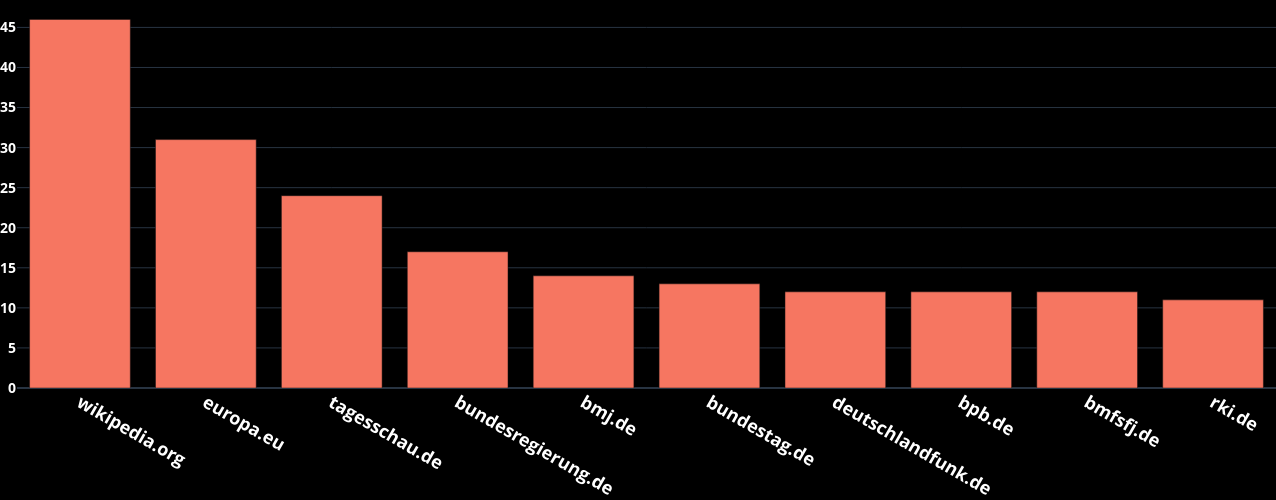

In [44]:
visualize_sources_per_category_barchart_presentation(sources_per_category, 'politik', 'perp')

In [45]:
def visualize_sources_per_category_venn_presentation(data, category):
    '''
    Visualizes unique sources for a given category using a Venn diagram.
    :param dict data: Dict with {<category>: {<google>: [(term, frequency)], <perp>: [(term, frequency)]}}
    :param str category: The category to display
    '''
    # Prepare data
    all_google_sources = [x[0] for x in data[category]['google']]
    all_perp_sources = [x[0] for x in data[category]['perp']]
    common = set(all_google_sources).intersection(set(all_perp_sources))
    google_sources = set(all_google_sources) - set(all_perp_sources)
    perp_sources = set(all_perp_sources) - set(all_google_sources)
    # Create figure
    fig = go.Figure()
    height = 900
    width = height * 1.5
    font_size = 15
    circle_bottom = height/8
    circle_top = 7*height/8
    circle_height = circle_top - circle_bottom
    equal_space_common = circle_height / (len(common) + 1)
    equal_space_google = circle_height / (len(google_sources) + 1)
    equal_space_perp = circle_height / (len(perp_sources) + 1)
    fig.add_shape(
        type='circle',
        x0=0,
        x1=5.5*width/8,
        y0=circle_bottom,
        y1=circle_top,
        fillcolor='#F67661',
        line_color='#F67661',
        opacity=0.8
    )
    fig.add_shape(
        type='circle',
        x0=2.5*width/8,
        x1=8*width/8,
        y0=circle_bottom,
        y1=circle_top,
        fillcolor='#F67661',
        line_color='#F67661',
        opacity=0.8
    )
    for i, v in enumerate(google_sources):
        position = circle_bottom + equal_space_google * (i + 1)
        fig.add_annotation(x=2*width/8, y=position, text=v, showarrow=False, font=dict(size=font_size, weight='bold', color='black'))
    for i, v in enumerate(common):
        position = circle_bottom + equal_space_common * (i + 1)
        fig.add_annotation(x=width/2, y=position, text=v, showarrow=False, font=dict(size=font_size, weight='bold', color='black'))
    for i, v in enumerate(perp_sources):
        position = circle_bottom + equal_space_perp * (i + 1)
        fig.add_annotation(x=6*width/8, y=position, text=v, showarrow=False, font=dict(size=font_size, weight='bold', color='black'))
    fig.update_layout(
        title=category,
        showlegend=False,
        width=width,
        height=height,
        template='plotly_dark',
        paper_bgcolor='black',
        plot_bgcolor='black',
        margin=dict(l=0, r=0, t=0, b=0),
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            visible=False,
            scaleanchor='y',
            scaleratio=1,
            range=[0, width]
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            visible=False,
            range=[0, height]
        )
    )
    return fig

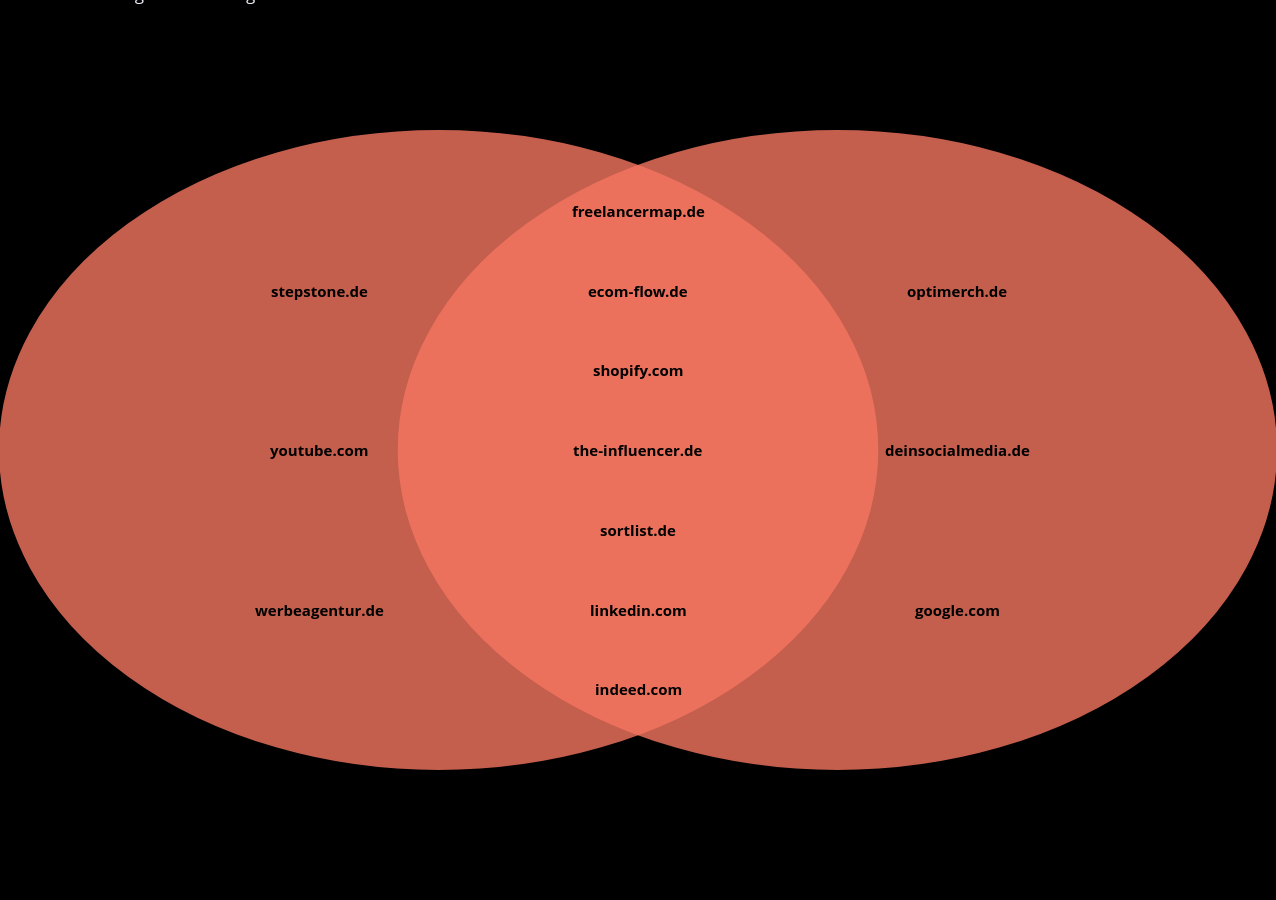

In [46]:
visualize_sources_per_category_venn_presentation(sources_per_category, 'marketingdienstleistungen')

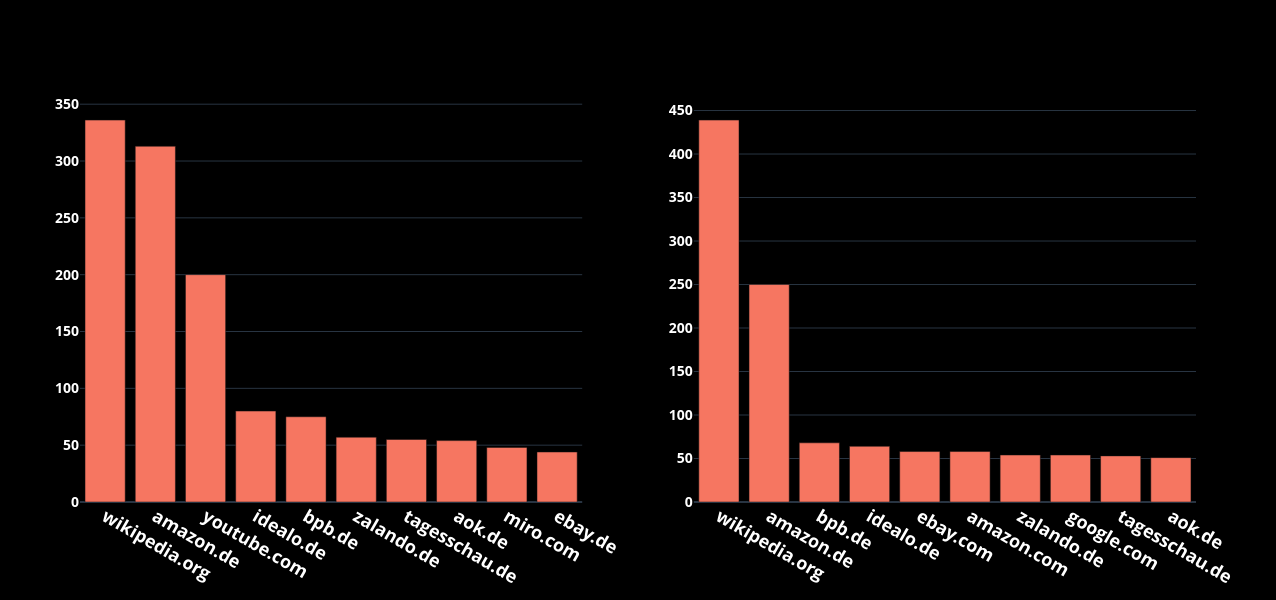

In [47]:
# Pair plot of top-10 sources for the whole dataset
fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Bar(
        x=[x[0] for x in most_common_total_google],
        y=[x[1] for x in most_common_total_google],
        marker_color='#F67661',
        showlegend=False
    ),
    row=1, col=1
)
fig.add_trace(
    go.Bar(
        x=[x[0] for x in most_common_total_perp],
        y=[x[1] for x in most_common_total_perp],
        marker_color='#F67661',
        showlegend=False
    ),
    row=1, col=2
)
fig.update_layout(
    template='plotly_dark',
    height=600,
    paper_bgcolor='black',
    plot_bgcolor='black'
)
fig.update_xaxes(
    tickfont=dict(size=18, color='white', weight='bold'),
    row=1, col=1
)
fig.update_xaxes(
    tickfont=dict(size=18, color='white', weight='bold'),
    row=1, col=2
)
fig.update_yaxes(
    tickfont=dict(size=14, color='white', weight='bold'),
    row=1, col=1
)
fig.update_yaxes(
    tickfont=dict(size=14, color='white', weight='bold'),
    row=1, col=2
)

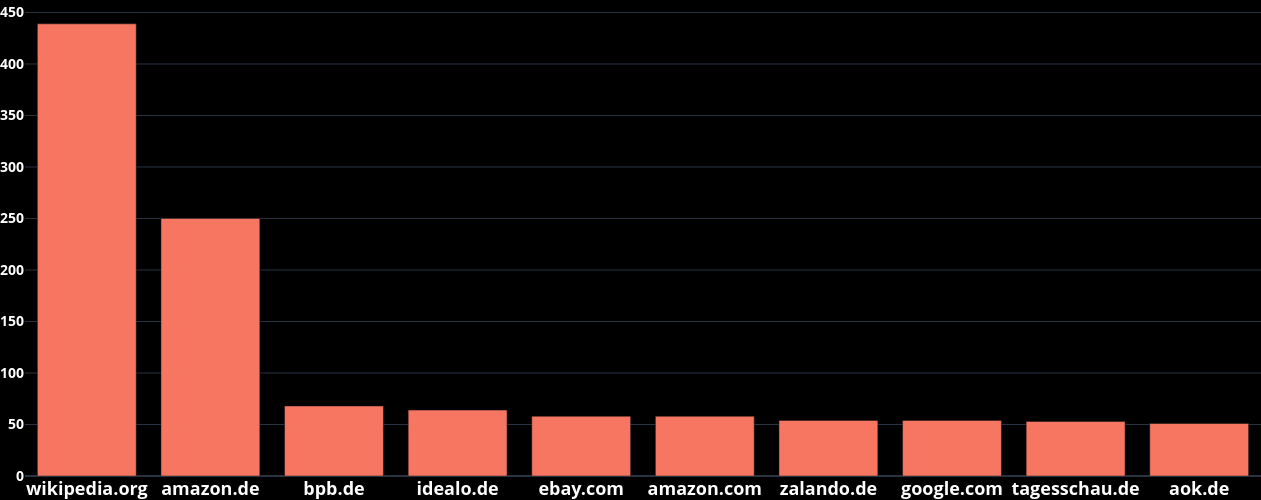

In [48]:
# Pair plot of top-10 sources for either Google or Perplexity
fig = make_subplots(rows=1, cols=1)
fig.add_trace(
    go.Bar(
        x=[x[0] for x in most_common_total_perp],
        y=[x[1] for x in most_common_total_perp],
        marker_color='#F67661',
        showlegend=False
    ),
    row=1, col=1
)
fig.update_layout(
    template='plotly_dark',
    height=500,
    width=800,
    paper_bgcolor='black',
    plot_bgcolor='black',
    margin=dict(l=0, r=0, t=0, b=0)
)
fig.update_xaxes(
    tickfont=dict(size=18, color='white', weight='bold'),
    row=1, col=1
)
fig.update_yaxes(
    tickfont=dict(size=14, color='white', weight='bold'),
    row=1, col=1
)